# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

In [2]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers, regularizers

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Load the dataset from your Drive folder
path = '/content/gdrive/MyDrive/Colab Notebooks/Data_Getting_Start_TF'

train = loadmat(path+'/train_32x32.mat')
test  = loadmat(path+'/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
# Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.

x_train = train['X']/255.0
x_train = np.moveaxis(x_train, -1, 0)
x_test = test['X']/255.0
x_test = np.moveaxis(x_test, -1, 0)

y_train = train['y']
y_train[y_train == 10] = 0
y_test = test['y']
y_test[y_test == 10] = 0

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 1)
(26032, 1)


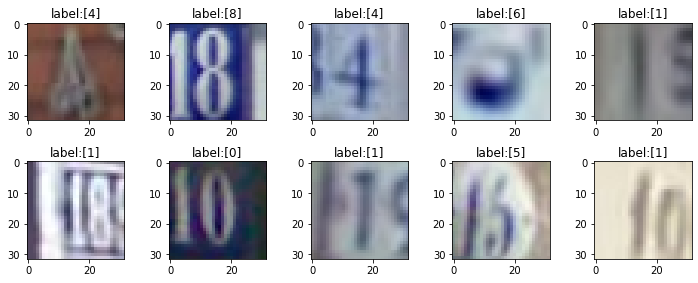

In [6]:
# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
inicio = np.random.randint(x_train.shape[0], size=(1, 10))[0] 

rows, cols = 2, 5
axes=[]
fig=plt.figure(figsize=(10,4))

for ind,i in enumerate(inicio):
    axes.append( fig.add_subplot(rows, cols, ind+1) )
    subplot_title=('label:'+ str(y_train[i]))
    axes[-1].set_title(subplot_title)  
    img = x_train[i,:,:,:]
    plt.imshow(img)
fig.tight_layout()    
plt.show()

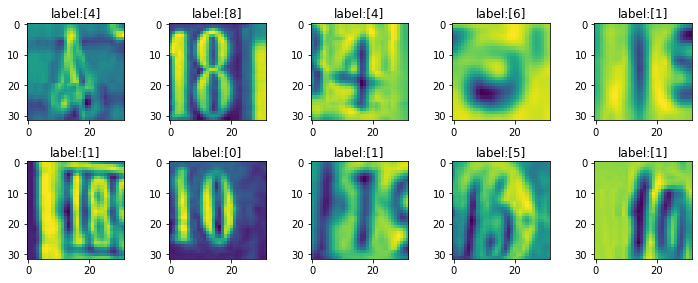

In [7]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.
x_train = np.mean(x_train, axis=3,keepdims=True)
x_test  = np.mean(x_test , axis=3,keepdims=True)

rows, cols = 2, 5
axes=[]
fig=plt.figure(figsize=(10,4))

for ind,i in enumerate(inicio):
    axes.append( fig.add_subplot(rows, cols, ind+1) )
    subplot_title=('label:'+ str(y_train[i]))
    axes[-1].set_title(subplot_title)  
    img = x_train[i,:,:,0]
    #plt.imshow(img,interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.imshow(img)
fig.tight_layout()    
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [8]:
def get_model():
    model = Sequential([
        Flatten(input_shape = (32,32,1)),
        Dense(64 , activation = 'softplus', 
              kernel_initializer='he_normal', bias_initializer=tf.keras.initializers.Constant(1.)), # activation = 'softplus',
        Dense(64 , activation = 'relu'),
        Dense(64 , activation = 'relu'),
        Dense(64 , activation = 'relu'),
        Dense(10 , activation = 'softmax')
    ])
    
    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Run my function to get the model
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 78,730
Trainable params: 78,730
Non-traina

In [9]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('loss: {acc:0.3f}'.format(acc=test_loss))
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

get_test_accuracy(model, x_test, y_test)

loss: 2.725
accuracy: 0.092


In [10]:
# Creating Checkpoints

def get_checkpoint_best_only():
    checkpoint_best_path = 'checkpoints_best_MLP/checkpoint'
    checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                      monitor='val_accuracy',
                                      save_weights_only=True,
                                      save_freq='epoch',
                                      save_best_only = True,
                                      verbose=1)
    return checkpoint_best

def get_early_stopping():
    callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor="accuracy")
    return callback


checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [11]:
history = model.fit(x_train, y_train, epochs=25,
                    validation_data=(x_test, y_test),
                    batch_size = 64, callbacks=callbacks)

Epoch 1/25
1138/1145 [============================>.] - ETA: 0s - loss: 2.2393 - accuracy: 0.1872
Epoch 1: val_accuracy improved from -inf to 0.19618, saving model to checkpoints_best_MLP/checkpoint
1145/1145 [==============================] - 6s 4ms/step - loss: 2.2393 - accuracy: 0.1871 - val_loss: 2.2222 - val_accuracy: 0.1962
Epoch 2/25
1142/1145 [============================>.] - ETA: 0s - loss: 2.2304 - accuracy: 0.1894
Epoch 2: val_accuracy did not improve from 0.19618
1145/1145 [==============================] - 4s 3ms/step - loss: 2.2303 - accuracy: 0.1894 - val_loss: 2.2090 - val_accuracy: 0.1959
Epoch 3/25
1138/1145 [============================>.] - ETA: 0s - loss: 2.2111 - accuracy: 0.1953
Epoch 3: val_accuracy improved from 0.19618 to 0.20970, saving model to checkpoints_best_MLP/checkpoint
1145/1145 [==============================] - 4s 4ms/step - loss: 2.2109 - accuracy: 0.1954 - val_loss: 2.1676 - val_accuracy: 0.2097
Epoch 4/25
1137/1145 [============================>

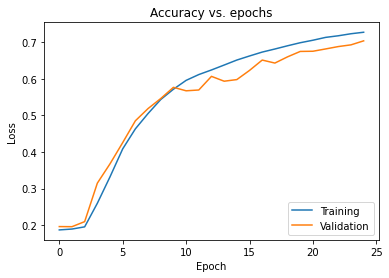

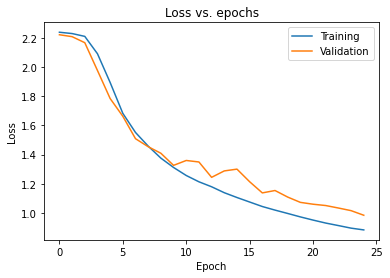

In [12]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
def get_new_model(dropout_rate):
    model = Sequential([
        Conv2D(filters=8, input_shape=(32,32,1), kernel_size=(3, 3), 
               activation='softplus',padding='same', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu',padding='same', name='conv_2'),
        MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=64 , activation='sigmoid', name='dense_1'), #kernel_regularizer = regularizers.l2(wd),
        Dropout(dropout_rate),
        Dense(units=128, activation='sigmoid', name='dense_2'),
        BatchNormalization(),
        Dense(units=64 , activation='relu', name='dense_3'),
        Dropout(dropout_rate),
        Dense(units=10 , activation='softmax', name='dense_4')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_CNN = get_new_model(0.1)
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 8)         584       
                                                                 
 pool_1 (MaxPooling2D)       (None, 4, 4, 8)           0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [14]:
# Creating Checkpoints

def get_checkpoint_best_only():
    checkpoint_best_path = 'checkpoints_best_CNN/checkpoint'
    checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                      monitor='val_accuracy',
                                      save_weights_only=True,
                                      save_freq='epoch',
                                      save_best_only = True,
                                      verbose=1)
    return checkpoint_best

def get_early_stopping():
    callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor="accuracy")
    return callback


checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [15]:
history_CNN = model_CNN.fit(x_train, y_train, epochs=15,
                    validation_data=(x_test, y_test),
                    batch_size = 32, callbacks=callbacks)

Epoch 1/15
2290/2290 [==============================] - ETA: 0s - loss: 2.0326 - accuracy: 0.2693
Epoch 1: val_accuracy improved from -inf to 0.31000, saving model to checkpoints_best_CNN/checkpoint
2290/2290 [==============================] - 22s 5ms/step - loss: 2.0326 - accuracy: 0.2693 - val_loss: 2.0264 - val_accuracy: 0.3100
Epoch 2/15
2281/2290 [============================>.] - ETA: 0s - loss: 1.3611 - accuracy: 0.5386
Epoch 2: val_accuracy improved from 0.31000 to 0.60330, saving model to checkpoints_best_CNN/checkpoint
2290/2290 [==============================] - 11s 5ms/step - loss: 1.3606 - accuracy: 0.5388 - val_loss: 1.1786 - val_accuracy: 0.6033
Epoch 3/15
2286/2290 [============================>.] - ETA: 0s - loss: 1.1477 - accuracy: 0.6198
Epoch 3: val_accuracy improved from 0.60330 to 0.67697, saving model to checkpoints_best_CNN/checkpoint
2290/2290 [==============================] - 12s 5ms/step - loss: 1.1474 - accuracy: 0.6199 - val_loss: 1.0109 - val_accuracy: 0.

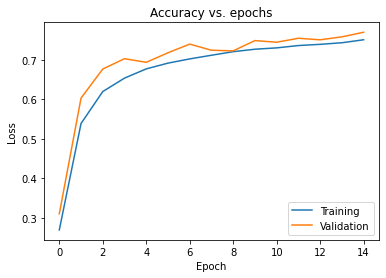

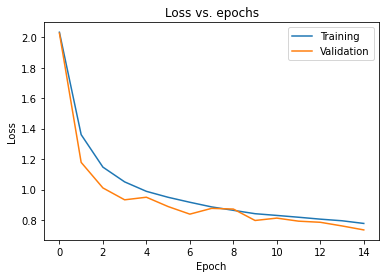

In [16]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history_CNN.history['accuracy'])
    plt.plot(history_CNN.history['val_accuracy'])
except KeyError:
    plt.plot(history_CNN.history['acc'])
    plt.plot(history_CNN.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

#Run this cell to plot the epoch vs loss graph
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [17]:
# Run this cell to define a function to evaluate a model's test accuracy and loss

def get_test_accuracy_CNN(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model_CNN.evaluate(x=x_test, y=y_test, verbose=0)
    print('loss: {acc:0.3f}'.format(acc=test_loss))
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

get_test_accuracy_CNN(model_CNN, x_test, y_test)

loss: 0.735
accuracy: 0.770


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [18]:
print(tf.train.latest_checkpoint('checkpoints_best_MLP'))
print(tf.train.latest_checkpoint('checkpoints_best_CNN'))

checkpoints_best_MLP/checkpoint
checkpoints_best_CNN/checkpoint


#MLP - Predictions

In [19]:
def get_model_best_epoch_MLP(model):
    checkpoint_path = 'checkpoints_best_MLP/checkpoint'
    model.load_weights(checkpoint_path)
    return model

model_best_epoch_MLP = get_model_best_epoch_MLP(get_model())

print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch_MLP, x_test, y_test)

Model with best epoch weights:
loss: 0.983
accuracy: 0.704


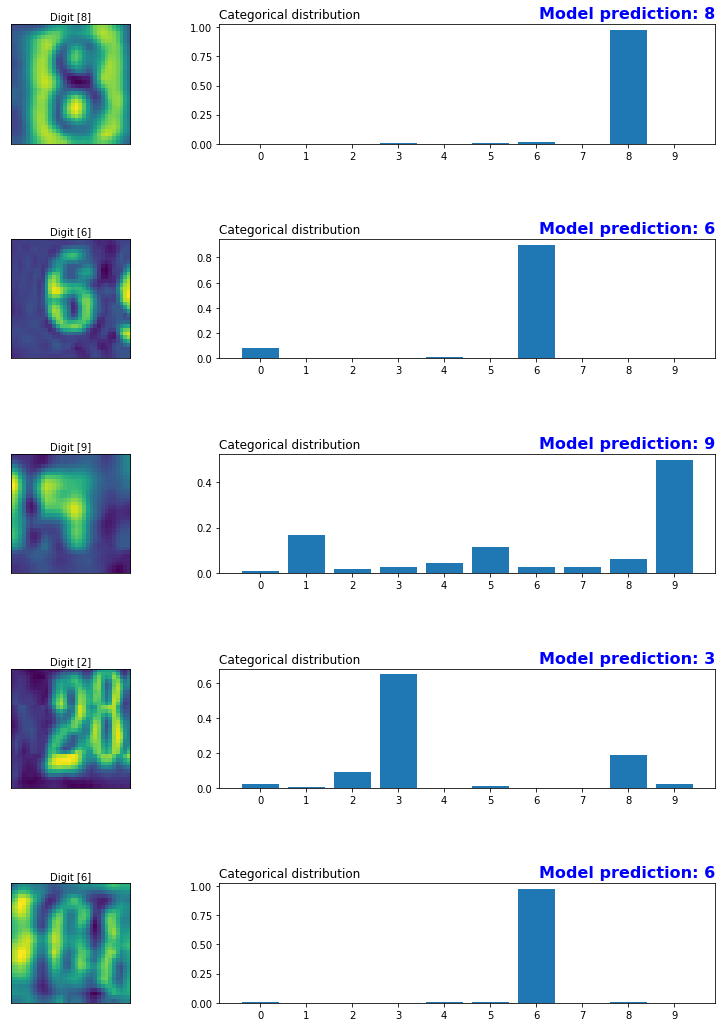

In [31]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 18))
fig.subplots_adjust(hspace=0.8, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("Categorical distribution", loc='left')
    axes[i, 1].set_title(f"Model prediction: {np.argmax(prediction)}", 
          fontdict={'color' : 'blue',
                    'weight': 'bold',
                    'size': 16},
          loc='right')
    
plt.show()

#CNN - Predictions

In [34]:
def get_model_best_epoch(model):
    checkpoint_path = 'checkpoints_best_CNN/checkpoint'
    model.load_weights(checkpoint_path)
    return model

model_best_epoch = get_model_best_epoch(get_new_model(0.1))

print('Model with best epoch weights:')
get_test_accuracy_CNN(model_best_epoch, x_test, y_test)

Model with best epoch weights:
loss: 0.735
accuracy: 0.770


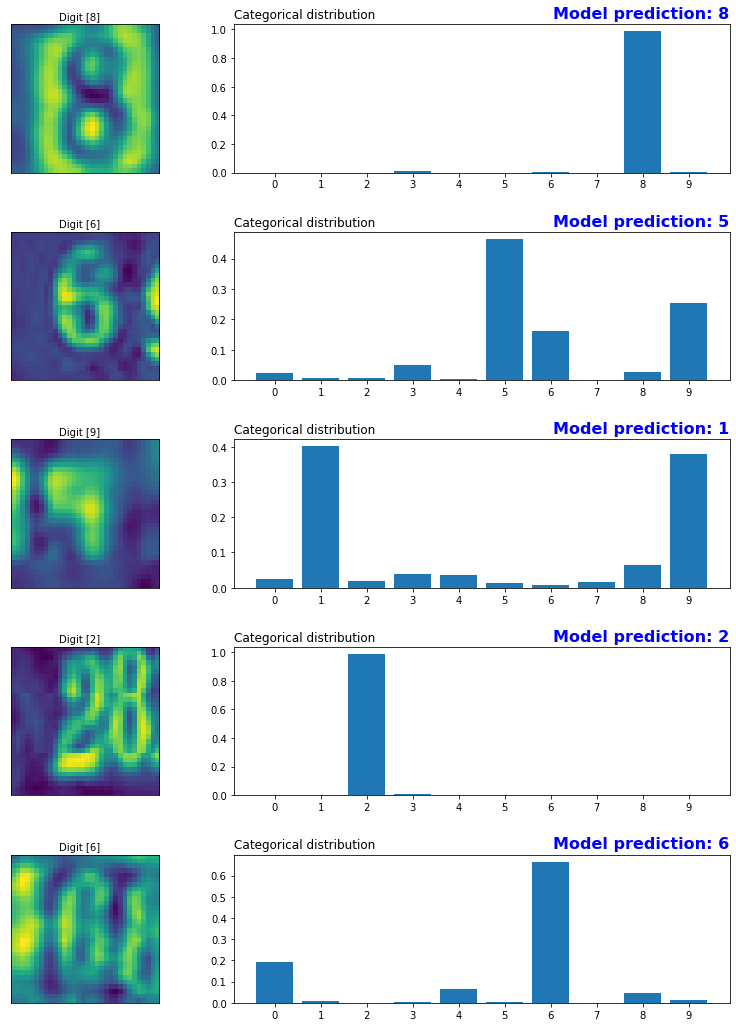

In [33]:
# Run this cell to get model predictions on randomly selected test images

#num_test_images = x_test.shape[0]

#random_inx = np.random.choice(num_test_images, 5)
#random_test_images = x_test[random_inx, ...]
#random_test_labels = y_test[random_inx, ...]

predictions = model_CNN.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 18))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title("Categorical distribution", loc='left')
    axes[i, 1].set_title(f"Model prediction: {np.argmax(prediction)}", 
          fontdict={'color' : 'blue',
                    'weight': 'bold',
                    'size': 16},
          loc='right')
    
plt.show()

## Conclusions:

+ A lower loss was obtained in the CNN vs MLP model using fewer parameters and with fewer epochs
+ Similarly, a higher accuracy was obtained in the CNN vs MLP model using fewer parameters and with fewer epochs.